Импортируем необходимые либы

In [1]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [2]:
tqdm.pandas()

device = torch.device('cuda')

Скачиваем предобученные BERT трансформеры DeepPavlov

In [ ]:
bert = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

Загружаем датасет, исходя из поставленной оценки формируем датасет с двумя классами (1 - positive_reviews, 0 - negative_reviews), затем DownSample'им чтобы сбалансировать классы.

In [4]:
df = pd.read_csv("reviews.csv")

df.rating.value_counts()

5    3433
1     502
4      87
2      69
3      26
Name: rating, dtype: int64

In [5]:
df = df[df.rating != 4]

df.loc[df["rating"] < 4, "rating"] = 0

df.loc[df["rating"] > 4, "rating"] = 1

df.rating.value_counts()

1    3433
0     597
Name: rating, dtype: int64

In [6]:
positive_reviews = df[df["rating"] == 1]
negative_reviews  = df[df["rating"] == 0]
print(positive_reviews.shape)
print(negative_reviews.shape)

(3433, 5)
(597, 5)


In [7]:
from sklearn.utils import resample
positive_downsample = resample(positive_reviews,
             replace=True,
             n_samples=len(negative_reviews),
             random_state=42)

print(positive_downsample.shape)

(597, 5)


1    597
0    597
Name: rating, dtype: int64


<Axes: ylabel='Type'>

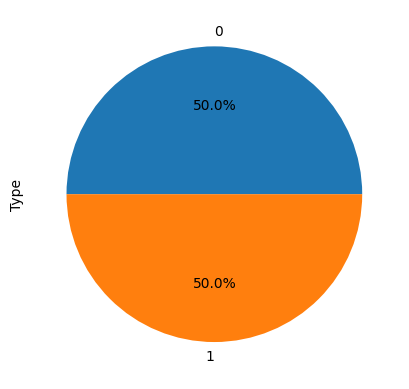

In [8]:
reviews_downsampled = pd.concat([positive_downsample, negative_reviews])

print(reviews_downsampled["rating"].value_counts())

reviews_downsampled.groupby('rating').size().plot(kind='pie',
                                       y = "v1",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [9]:
from sklearn.model_selection import train_test_split

reviews_train, reviews_test1 = train_test_split(reviews_downsampled, test_size=0.4, random_state=42)
reviews_test, reviews_val = train_test_split(reviews_test1, test_size=0.5, random_state=42)

print(reviews_train.shape)
print(reviews_val.shape)
print(reviews_test.shape)


(716, 5)
(239, 5)
(239, 5)


In [ ]:
reviews_train.head(20)

Разобьем выборки на отзыв и таргет

In [11]:
train_reviews = reviews_train['message'].astype('str')
train_labels = reviews_train['rating']
val_reviews = reviews_val['message'].astype('str')
val_labels = reviews_val['rating']
test_reviews = reviews_test['message'].astype('str')
test_labels = reviews_test['rating']

Подберем оптимальную длину последовательности токенов, чтобы избежать  разреженных векторов

<Axes: >

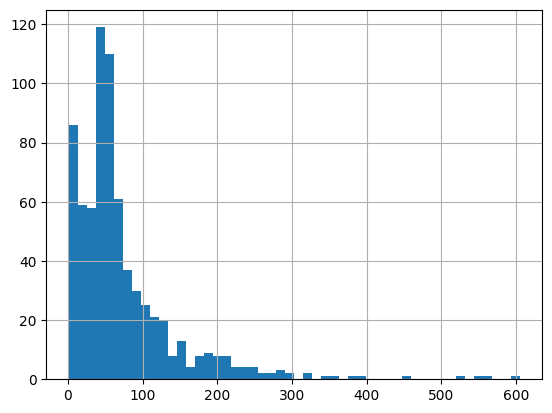

In [12]:
seq_len = [len(str(i).split()) for i in train_reviews]
pd.Series(seq_len).hist(bins = 50)

# около 100 токенов достаточно

Теперь токенизируем отзывы и переведем в Tensor

In [13]:
tokens_train = tokenizer.batch_encode_plus(
    train_reviews.values,
    max_length = 100,
    padding = 'max_length',
    truncation = True
)
tokens_val = tokenizer.batch_encode_plus(
    val_reviews.values,
    max_length = 100,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    test_reviews.values,
    max_length = 100,
    padding = 'max_length',
    truncation = True
)

In [14]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.values)

In [15]:
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.values)

In [16]:
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.values)

Создадим DataLoader с размером батчей BATCH_SIZE, благодаря которому будем обучать на порциях данных

In [17]:
BATCH_SIZE = 8

In [18]:
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = BATCH_SIZE)

val_data =  TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = BATCH_SIZE)

Теперь реализуем саму архитектуру модели, сам BERT трогать не будем, просто к выходу допишем слои и обучим уже их на классификацию

In [19]:
for param in bert.parameters():
    param.requires_grad = False

class BERT_tune(nn.Module):

    def __init__(self, bert):
        super(BERT_tune, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,2)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

Объявляем модель и загружаем в GPU

In [72]:
model = BERT_tune(bert)

model = model.to(device)

После некоторых сравнений, выберем наиболее релевантный оптимизатор и LOSS-функцию

In [73]:
from transformers import AdamW

optimizer = AdamW(model.parameters(),
               lr= 1e-3)

cross_entropy = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Для начала обучим на 20 эпохах

In [74]:
EPOCHS = 50

Функция для обучения

In [76]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

Функция для валидации

In [77]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

Обучаем модель, сохраняем веса лучших метрик!

In [78]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(EPOCHS):
    print('\n Epoch{:} / {:}'.format(epoch+1, EPOCHS))

    train_loss, _ = train()
    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')


 Epoch1 / 50


100%|██████████| 30/30 [00:01<00:00, 21.05it/s]



Training loss: 0.594
Validation loss: 0.521

 Epoch2 / 50


100%|██████████| 30/30 [00:01<00:00, 20.67it/s]



Training loss: 0.515
Validation loss: 0.530

 Epoch3 / 50


100%|██████████| 30/30 [00:01<00:00, 20.28it/s]



Training loss: 0.492
Validation loss: 0.532

 Epoch4 / 50


100%|██████████| 30/30 [00:01<00:00, 19.93it/s]



Training loss: 0.449
Validation loss: 0.532

 Epoch5 / 50


100%|██████████| 30/30 [00:01<00:00, 19.64it/s]



Training loss: 0.479
Validation loss: 0.551

 Epoch6 / 50


100%|██████████| 30/30 [00:01<00:00, 19.62it/s]



Training loss: 0.450
Validation loss: 0.712

 Epoch7 / 50


100%|██████████| 30/30 [00:01<00:00, 19.79it/s]



Training loss: 0.442
Validation loss: 0.532

 Epoch8 / 50


100%|██████████| 30/30 [00:01<00:00, 20.15it/s]



Training loss: 0.429
Validation loss: 0.563

 Epoch9 / 50


100%|██████████| 30/30 [00:01<00:00, 20.30it/s]



Training loss: 0.435
Validation loss: 0.517

 Epoch10 / 50


100%|██████████| 30/30 [00:01<00:00, 21.20it/s]



Training loss: 0.393
Validation loss: 0.680

 Epoch11 / 50


100%|██████████| 30/30 [00:01<00:00, 20.70it/s]



Training loss: 0.407
Validation loss: 0.628

 Epoch12 / 50


100%|██████████| 30/30 [00:01<00:00, 20.46it/s]



Training loss: 0.405
Validation loss: 0.605

 Epoch13 / 50


100%|██████████| 30/30 [00:01<00:00, 20.00it/s]



Training loss: 0.401
Validation loss: 0.500

 Epoch14 / 50


100%|██████████| 30/30 [00:01<00:00, 19.63it/s]



Training loss: 0.424
Validation loss: 0.643

 Epoch15 / 50


100%|██████████| 30/30 [00:01<00:00, 19.55it/s]



Training loss: 0.403
Validation loss: 0.706

 Epoch16 / 50


100%|██████████| 30/30 [00:01<00:00, 19.81it/s]



Training loss: 0.406
Validation loss: 0.557

 Epoch17 / 50


100%|██████████| 30/30 [00:01<00:00, 20.02it/s]



Training loss: 0.390
Validation loss: 0.524

 Epoch18 / 50


100%|██████████| 30/30 [00:01<00:00, 20.33it/s]



Training loss: 0.384
Validation loss: 0.527

 Epoch19 / 50


100%|██████████| 30/30 [00:01<00:00, 20.35it/s]



Training loss: 0.361
Validation loss: 0.502

 Epoch20 / 50


100%|██████████| 30/30 [00:01<00:00, 20.65it/s]



Training loss: 0.361
Validation loss: 0.513

 Epoch21 / 50


100%|██████████| 30/30 [00:01<00:00, 20.67it/s]



Training loss: 0.378
Validation loss: 0.537

 Epoch22 / 50


100%|██████████| 30/30 [00:01<00:00, 20.76it/s]



Training loss: 0.332
Validation loss: 0.583

 Epoch23 / 50


100%|██████████| 30/30 [00:01<00:00, 20.66it/s]



Training loss: 0.354
Validation loss: 0.497

 Epoch24 / 50


100%|██████████| 30/30 [00:01<00:00, 20.81it/s]



Training loss: 0.379
Validation loss: 0.504

 Epoch25 / 50


100%|██████████| 30/30 [00:01<00:00, 20.66it/s]



Training loss: 0.381
Validation loss: 0.482

 Epoch26 / 50


100%|██████████| 30/30 [00:01<00:00, 20.28it/s]



Training loss: 0.364
Validation loss: 0.540

 Epoch27 / 50


100%|██████████| 30/30 [00:01<00:00, 20.03it/s]



Training loss: 0.348
Validation loss: 0.473

 Epoch28 / 50


100%|██████████| 30/30 [00:01<00:00, 20.03it/s]



Training loss: 0.361
Validation loss: 0.658

 Epoch29 / 50


100%|██████████| 30/30 [00:01<00:00, 20.19it/s]



Training loss: 0.370
Validation loss: 0.458

 Epoch30 / 50


100%|██████████| 30/30 [00:01<00:00, 20.20it/s]



Training loss: 0.334
Validation loss: 0.475

 Epoch31 / 50


100%|██████████| 30/30 [00:01<00:00, 20.15it/s]



Training loss: 0.335
Validation loss: 0.601

 Epoch32 / 50


100%|██████████| 30/30 [00:01<00:00, 20.18it/s]



Training loss: 0.319
Validation loss: 0.528

 Epoch33 / 50


100%|██████████| 30/30 [00:01<00:00, 20.36it/s]



Training loss: 0.328
Validation loss: 0.526

 Epoch34 / 50


100%|██████████| 30/30 [00:01<00:00, 20.35it/s]



Training loss: 0.314
Validation loss: 0.610

 Epoch35 / 50


100%|██████████| 30/30 [00:01<00:00, 20.38it/s]



Training loss: 0.333
Validation loss: 0.671

 Epoch36 / 50


100%|██████████| 30/30 [00:01<00:00, 20.51it/s]



Training loss: 0.356
Validation loss: 0.526

 Epoch37 / 50


100%|██████████| 30/30 [00:01<00:00, 20.55it/s]



Training loss: 0.318
Validation loss: 0.507

 Epoch38 / 50


100%|██████████| 30/30 [00:01<00:00, 20.65it/s]



Training loss: 0.358
Validation loss: 0.512

 Epoch39 / 50


100%|██████████| 30/30 [00:01<00:00, 20.52it/s]



Training loss: 0.312
Validation loss: 0.531

 Epoch40 / 50


100%|██████████| 30/30 [00:01<00:00, 20.42it/s]



Training loss: 0.292
Validation loss: 0.534

 Epoch41 / 50


100%|██████████| 30/30 [00:01<00:00, 20.45it/s]



Training loss: 0.345
Validation loss: 0.502

 Epoch42 / 50


100%|██████████| 30/30 [00:01<00:00, 20.44it/s]



Training loss: 0.296
Validation loss: 0.510

 Epoch43 / 50


100%|██████████| 30/30 [00:01<00:00, 20.32it/s]



Training loss: 0.341
Validation loss: 0.628

 Epoch44 / 50


100%|██████████| 30/30 [00:01<00:00, 20.28it/s]



Training loss: 0.317
Validation loss: 0.504

 Epoch45 / 50


100%|██████████| 30/30 [00:01<00:00, 20.27it/s]



Training loss: 0.287
Validation loss: 0.592

 Epoch46 / 50


100%|██████████| 30/30 [00:01<00:00, 20.34it/s]



Training loss: 0.331
Validation loss: 0.484

 Epoch47 / 50


100%|██████████| 30/30 [00:01<00:00, 20.40it/s]



Training loss: 0.296
Validation loss: 0.575

 Epoch48 / 50


100%|██████████| 30/30 [00:01<00:00, 20.39it/s]



Training loss: 0.287
Validation loss: 0.643

 Epoch49 / 50


100%|██████████| 30/30 [00:01<00:00, 20.45it/s]



Training loss: 0.331
Validation loss: 0.803

 Epoch50 / 50


100%|██████████| 30/30 [00:01<00:00, 20.31it/s]


Training loss: 0.309
Validation loss: 0.624


Загружаем лучшие веса модели

In [26]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

Далее идем проверять на тестовой выборке

In [28]:
import gc
gc.collect()
torch.cuda.empty_cache()

list_seq = np.array_split(test_seq, 50)
list_mask = np.array_split(test_mask, 50)


predictions = []
for num, elem in enumerate(list_seq):
    with torch.no_grad():
        preds = model(elem.to(device), list_mask[num].to(device))
        predictions.append(preds.detach().cpu().numpy())

Преобразуем полученные предсказания в один список, нормализуем данные и запишем в новый столбик датафрейма.



In [29]:
flat_preds = [item[1] for sublist in predictions for item in sublist]
flat_preds = (flat_preds - min(flat_preds)) / (max(flat_preds) - min(flat_preds))
reviews_test['confidence'] = flat_preds

На выходе мы получили значение с плавающей точкой от 0 до 1. Теперь меняя порог, мы сможем предсказать финальный класс:

In [67]:
reviews_test['pred'] = reviews_test['confidence'].apply(lambda x: 1 if x>0.88 else 0)

print(classification_report(reviews_test['rating'], reviews_test['pred']))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       116
           1       0.91      0.78      0.84       123

    accuracy                           0.85       239
   macro avg       0.86      0.85      0.85       239
weighted avg       0.86      0.85      0.85       239



Теперь проверим на рандомном отзывы о Тинькофф

In [69]:
reviews = ['У банка очень хорошая техническая поддержка через нее вернул порядко 4000₽ который украли мошейники. Также хочу похвалить их за то что дают открывать счета, инвестировать. Представители всегда опрятные вежливые ответят на любые ваши вопросы по...',
           'Самый лучший банк в стране по моему мнению! Интересное приложение! Много акций всегда! С большим удовольствием пользуюсь картой данного банка во всех магазинах, интернет-магазинах, оплачивают счета ЖКХ.',
           'заблокировали бонусные баллы и вынудили закрыть карту без компенсации бонусов. была акция кешбек 10% - я сделал заказ, оплатил и тут пришло сообщение что бонусная программа заблокирована без объяснения причин. в течении года пытался добиться...']

token_r = tokenizer.batch_encode_plus(
    np.array(reviews),
    max_length = 100,
    padding = 'max_length',
    truncation = True
)


r_seq = torch.tensor(token_r['input_ids'])
r_mask = torch.tensor(token_r['attention_mask'])

gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
        pred = model(r_seq.to(device), r_mask.to(device))
        pred = pred.detach().cpu().numpy()

flat_pred = np.array([item[1] for item in pred])
flat_pred = (flat_pred - min(flat_pred)) / (max(flat_pred) - min(flat_pred))

flat_pred

array([1.        , 0.91511494, 0.        ], dtype=float32)